In [113]:

import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
import json
nltk.download('vader_lexicon')
nltk.download('twitter_samples')
nltk.download('punkt')
import seaborn as sns

#importieren der Trainigsdaten---nltk stellt tweets dafür bereit
from nltk.corpus import twitter_samples

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\misarasa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\misarasa\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\misarasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [114]:
pos_twee = twitter_samples.strings('positive_tweets.json')
neg_twee = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [115]:
print(pos_twee[0])

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)


In [116]:
print(len(text))
print(len(pos_twee))
print(len(neg_twee))

20000
5000
5000


In [117]:
df = pd.DataFrame (pos_twee,columns=['text'])
df['Value'] = 1
df2 = pd.DataFrame (neg_twee,columns=['text'])
df2['Value'] = -1

In [118]:
df

,text,Value
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1
...,...,...
4995,"@chriswiggin3 Chris, that's great to hear :) D...",1
4996,@RachelLiskeard Thanks for the shout-out :) It...,1
4997,@side556 Hey! :) Long time no talk...,1
4998,@staybubbly69 as Matt would say. WELCOME TO AD...,1


In [119]:
df2

,text,Value
0,hopeless for tmr :(,-1
1,Everything in the kids section of IKEA is so c...,-1
2,@Hegelbon That heart sliding into the waste ba...,-1
3,"“@ketchBurning: I hate Japanese call him ""bani...",-1
4,"Dang starting next week I have ""work"" :(",-1
...,...,...
4995,I wanna change my avi but uSanele :(,-1
4996,MY PUPPY BROKE HER FOOT :(,-1
4997,where's all the jaebum baby pictures :((,-1
4998,But but Mr Ahmad Maslan cooks too :( https://t...,-1


In [120]:
df=df.append(df2, ignore_index = True)

In [121]:
df = df.sample(frac=1).reset_index(drop=True) #msichen der positiven und negativen tweets


In [122]:
df


,text,Value
0,How sad what happened in Louisiana...:(,-1
1,@sellosekhobela Hello :) We offer internships ...,1
2,Happy family vacation .. :D [pic] — https://t....,1
3,@monifizzle hahah no boys came for my milkshak...,-1
4,"@DaveHShaw Hi Dave, please contact our in-App ...",1
...,...,...
9995,@JonsCrazyTweets I actually tried that blend i...,1
9996,Isco :(,-1
9997,i love got7's outfit for just right &gt;:( its...,-1
9998,@YM_Dish98 doushite :( ?,-1


# bereinigen der Daten

In [123]:
#bereinigen der Tweets
remove_rt = lambda x: re.sub("(RT @\w+: )|(@\w+):"," ",x) #herausfiltern der usernamen und RT
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|[\d\.]|(\w+:\/\/\S+)|(\n|\t|\')"," ",x) #herausfiltern markierter Usernamen 
htp = lambda x: re.sub('http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ",x) #entfernen von links, sonderzeichen, punkten

df["text"] = df.text.map(remove_rt).map(rt).map(htp)
df["text"] = df.text.str.lower()
df.text.head(10)

0              how sad what happened in louisiana   :(
1      hello :) we offer internships in luxuous hot...
2                happy family vacation    :d [pic] —  
3               hahah no boys came for my milkshake :(
4      hi dave, please contact our in-app support c...
5      so hard to pick just one  the inca trail was...
6    and here s     s ★★★★ review:   phew! we re li...
7      kindly check your email  we re done sending ...
8       happy birthday for sunday! :) hope you have...
9                   rm   but still can negooo, male :)
Name: text, dtype: object

In [124]:
#bereinigen des textes von den Emojis
def deEmojify(text):
    regrex_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'',text)

df["text"] = df.text.map(deEmojify)

In [125]:
data = list(df["text"])
labels = list(df["Value"])

In [126]:
data[:5]

['how sad what happened in louisiana   :(',
 '  hello :) we offer internships in luxuous hotels worldwide, sure you ll find one for you &gt;&gt;  ',
 'happy family vacation    :d [pic] —  ',
 '  hahah no boys came for my milkshake :(',
 '  hi dave, please contact our in-app support chat so that we can ensure you get it on time! :)']

In [127]:
#from nltk.tokenize import word_tokenize


#data = list(map(lambda x: word_tokenize(x), data)) #tokenisieren der einzelnen zeichen
#data[:5]

In [128]:
#from sklearn.feature_extraction.text import CountVectorizer
# Counting the no of times each word(Unigram) appear in document. 
#vectorizer = CountVectorizer(input='content',binary=False,ngram_range=(1,1))
# First set the vocab
#vectorizer = vectorizer.random_state=42fit(data)
# Now transform the text contained in each document i.e list of text 
#print(vectorizer.get_feature_names())


In [129]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [130]:
print(len(data))
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42)

10000


In [131]:
x_train[:5]

['@    geetanjali well done, it s good to get thing out of the way :-))',
 '  do u raid in a good way? :)',
 'that feeling when someone shares a review you worked hard on :d',
 '!! nuggets and fries !! :-((',
 'i shoulda moved away w my boys when i had the chance cause they re the only people i want at times like this :(']

In [132]:
vectorizer = TfidfVectorizer()

In [133]:
vectors = vectorizer.fit_transform(data)

vectors_train = vectorizer.transform(x_train)
vectors_test = vectorizer.transform(x_test)

In [134]:
model = MultinomialNB(alpha=.01)
model = model.fit(vectors_train, y_train)

In [135]:
#--Tests von Miguel für Gridsearch--
from joblib import dump, load
from sklearn.metrics import classification_report
from nltk import word_tokenize
from nltk import WordNetLemmatizer

#Diese Wörter werden ignoriert
stopwords = ["able","about","above","abroad","according","accordingly","across","actually","adj","after","afterwards","again","against","ago","ahead","ain't","all","allow","allows","almost","alone","along","alongside","already","also","although","always","am","amid","amidst","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","a's","aside","ask","asking","associated","at","available","away","awfully","back","backward","backwards","be","became","because","become","becomes","becoming","been","before","beforehand","begin","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","came","can","cannot","cant","can't","caption","cause","causes","certain","certainly","changes","clearly","c'mon","co","co.","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","c's","currently","dare","daren't","definitely","described","despite","did","didn't","different","directly","do","does","doesn't","doing","done","don't","down","downwards","during","each","edu","eg","eight","eighty","either","else","elsewhere","end","ending","enough","entirely","especially","et","etc","even","ever","evermore","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","fairly","far","farther","few","fewer","fifth","first","five","followed","following","follows","for","forever","former","formerly","forth","forward","found","four","from","further","furthermore","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","had","hadn't","half","happens","hardly","has","hasn't","have","haven't","having","he","he'd","he'll","hello","help","hence","her","here","hereafter","hereby","herein","here's","hereupon","hers","herself","he's","hi","him","himself","his","hither","hopefully","how","howbeit","however","hundred","i'd","ie","if","ignored","i'll","i'm","immediate","in","inasmuch","inc","inc.","indeed","indicate","indicated","indicates","inner","inside","insofar","instead","into","inward","is","isn't","it","it'd","it'll","its","it's","itself","i've","just","k","keep","keeps","kept","know","known","knows","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","likewise","little","look","looking","looks","low","lower","ltd","made","mainly","make","makes","many","may","maybe","mayn't","me","mean","meantime","meanwhile","merely","might","mightn't","mine","minus","miss","more","moreover","most","mostly","mr","mrs","much","must","mustn't","my","myself","name","namely","nd","near","nearly","necessary","need","needn't","needs","neither","never","neverf","neverless","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","no-one","nor","normally","not","nothing","notwithstanding","novel","now","nowhere","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","one's","only","onto","opposite","or","other","others","otherwise","ought","oughtn't","our","ours","ourselves","out","outside","over","overall","own","particular","particularly","past","per","perhaps","placed","please","plus","possible","presumably","probably","provided","provides","que","quite","qv","rather","rd","re","really","reasonably","recent","recently","regarding","regardless","regards","relatively","respectively","right","round","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","shan't","she","she'd","she'll","she's","should","shouldn't","since","six","so","some","somebody","someday","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that's","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","there'd","therefore","therein","there'll","there're","theres","there's","thereupon","there've","these","they","they'd","they'll","they're","they've","thing","things","think","third","thirty","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","till","to","together","too","took","toward","towards","tried","tries","truly","try","trying","t's","twice","two","un","under","underneath","undoing","unfortunately","unless","unlike","unlikely","until","unto","up","upon","upwards","us","use","used","useful","uses","using","usually","v","value","various","versus","very","via","viz","vs","want","wants","was","wasn't","way","we","we'd","welcome","well","we'll","went","were","we're","weren't","we've","what","whatever","what'll","what's","what've","when","whence","whenever","where","whereafter","whereas","whereby","wherein","where's","whereupon","wherever","whether","which","whichever","while","whilst","whither","who","who'd","whoever","whole","who'll","whom","whomever","who's","whose","why","will","willing","wish","with","within","without","wonder","won't","would","wouldn't","yes","yet","you","you'd","you'll","your","you're","yours","yourself","yourselves","you've","zero","a","how's","i","when's","why's","b","c","d","e","f","g","h","j","l","m","n","o","p","q","r","s","t","u","uucp","w","x","y","z","I","www","amount","bill","bottom","call","computer","con","couldnt","cry","de","describe","detail","due","eleven","empty","fifteen","fifty","fill","find","fire","forty","front","full","give","hasnt","herse","himse","interest","itse”","mill","move","myse”","part","put","show","side","sincere","sixty","system","ten","thick","thin","top","twelve","twenty","abst","accordance","act","added","adopted","affected","affecting","affects","ah","announce","anymore","apparently","approximately","aren","arent","arise","auth","beginning","beginnings","begins","biol","briefly","ca","date","ed","effect","et-al","ff","fix","gave","giving","heres","hes","hid","home","id","im","immediately","importance","important","index","information","invention","itd","keys","kg","km","largely","lets","line","'ll","means","mg","million","ml","mug","na","nay","necessarily","nos","noted","obtain","obtained","omitted","ord","owing","page","pages","poorly","possibly","potentially","pp","predominantly","present","previously","primarily","promptly","proud","quickly","ran","readily","ref","refs","related","research","resulted","resulting","results","run","sec","section","shed","shes","showed","shown","showns","shows","significant","significantly","similar","similarly","slightly","somethan","specifically","state","states","stop","strongly","substantially","successfully","sufficiently","suggest","thered","thereof","therere","thereto","theyd","theyre","thou","thoughh","thousand","throug","til","tip","ts","ups","usefully","usefulness","'ve","vol","vols","wed","whats","wheres","whim","whod","whos","widely","words","world","youd","youre"]

class lemmaTokenizer: # Macht Konjugation rückgängig, allderdings nur auf Englisch
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())
#Vectorizer/Modell kann testweise hier geändert werden
pipe.fit(x_train, y_train) # Training ohne Hyperparameteroptimierung

print('-------------------------- Altes Modell -------------------------\n')
print(classification_report(y_test, pipe.predict(x_test), digits=4)) 
# anders als bestehendes Modell -> Fehler?
#print(pipe.get_params())

param_grid = {'multinomialnb__alpha': [0.01, 0.1, 0.25, 0.5, 1],
'multinomialnb__fit_prior' : [True, False],
'tfidfvectorizer__use_idf' : [True, False],
'tfidfvectorizer__norm': ['l1', 'l2'],
'tfidfvectorizer__stop_words' : [stopwords, None],                      
'tfidfvectorizer__tokenizer': [lemmaTokenizer, None],              
'tfidfvectorizer__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)]}


'''
gridsearch = GridSearchCV(pipe, param_grid, scoring = 'f1', cv=10, n_jobs = 16)
gridsearch.fit(x_train, y_train)
print("-------------------------- Grid Search -------------------------\n")
print(classification_report(y_test, gridsearch.predict(x_test), digits=4))
'''

print("-------------------------- Random Search -------------------------\n")
randomsearch = RandomizedSearchCV(pipe, param_grid, scoring = 'f1', cv=10, n_jobs = 16, n_iter = 100)
randomsearch.fit(x_train, y_train)
print(classification_report(y_test, randomsearch.predict(x_test), digits=4))
#dump(gridsearch, 'model.joblib') # Abspeichern des Modells

-------------------------- Altes Modell -------------------------

              precision    recall  f1-score   support

          -1     0.7662    0.8010    0.7832       769
           1     0.7802    0.7428    0.7610       731

    accuracy                         0.7727      1500
   macro avg     0.7732    0.7719    0.7721      1500
weighted avg     0.7730    0.7727    0.7724      1500

-------------------------- Random Search -------------------------



C:\Users\misarasa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 800 is smaller than n_iter=1000. Running 800 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

# Auswertung des Models

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(vectors_test), digits=4))

              precision    recall  f1-score   support

          -1     0.7125    0.7647    0.7377       765
           1     0.7349    0.6789    0.7058       735

    accuracy                         0.7227      1500
   macro avg     0.7237    0.7218    0.7218      1500
weighted avg     0.7235    0.7227    0.7221      1500



# Anreichern der Tweets

In [ ]:
#einlesen der Daten
data_tweets = pd.read_json("./cryptodoge.json", lines=True)
df_tweets=data_tweets


In [ ]:
#bereinigen der Tweets
remove_rt = lambda x: re.sub("(RT @\w+: )|(@\w+):"," ",x) #herausfiltern der usernamen und RT
rt = lambda x: re.sub("(@[A-Za-z0–9]+)|[\d\.]|(\w+:\/\/\S+)|(\n|\t|\')"," ",x) #herausfiltern markierter Usernamen 
htp = lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'," ",x) #entfernen von links, sonderzeichen, punkten

df_tweets["text"] = df.text.map(remove_rt).map(rt).map(htp)
df_tweets["text"] = df.text.str.lower()
df_tweets.text.head(10)

#bereinigen des textes von den Emojis
def deEmojify(text):
    regrex_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'',text)

df_tweets["text"] = df_tweets.text.map(deEmojify)

df_tweets.drop(df_tweets[df_tweets['lang'] != 'en'].index, inplace = True) #Modell ist nur für englisch trainiert -> nur Englisch auswerten

In [ ]:
df_tweets[:4]

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,lang,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities
0,2021-06-28 16:25:33+00:00,1409548535272407047,1409548535272407040,my feet hurt :(,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,en,2021-06-28 16:25:33.611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-28 16:25:33+00:00,1409548536740552712,1409548536740552704,"his headrest was loose, that s the reason...","<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,en,2021-06-28 16:25:33.961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-28 16:25:34+00:00,1409548538988609537,1409548538988609536,feel so sick :(,"<a href=""http://twitter.com/download/android"" ...",False,1.409546e+18,1.409546e+18,8.055323e+17,8.055323e+17,...,en,2021-06-28 16:25:34.497,"[16, 51]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-28 16:25:34+00:00,1409548540234194947,1409548540234194944,"they really are helpful :) alternatively, gi...","<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.406900e+18,1.406900e+18,1.074695e+18,1.074695e+18,...,en,2021-06-28 16:25:34.794,"[13, 140]",{'full_text': '@BitcoinAssn The most powerful ...,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
clean_data_list = list(df_tweets["text"])

In [ ]:
clean_data_list[:5]

['my feet hurt :(',
 '     his headrest was loose, that s the reason he pitted :-)',
 'feel so sick :(',
 '  they really are helpful :) alternatively, give us a call on     /               and we can help there  mka',
 '  make use of the masquerade mask!!!! lol #zorroreturms :-)']

In [ ]:
#kalkulieren der Wahrscheinlichkeiten des jeweiligen Textes

In [ ]:
one_test = vectorizer.transform(list(clean_data_list))

In [ ]:
prob_single=model.predict_proba(one_test)
prob_single

array([[0.20677418, 0.79322582],
       [0.01383248, 0.98616752],
       [0.95519193, 0.04480807],
       ...,
       [0.9734037 , 0.0265963 ],
       [0.94498089, 0.05501911],
       [0.99827181, 0.00172819]])

In [ ]:
neg_prob=[]
pos_prob=[]
print(type(neg_prob))

for i in prob_single:
    
    neg_prob.append(i[0])
    pos_prob.append(i[1])



<class 'list'>


In [ ]:
data_tweets["neg_prob"]=neg_prob
data_tweets["pos_prob"]=pos_prob

In [ ]:
data_tweets[:5]

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,display_text_range,extended_tweet,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,neg_prob,pos_prob
0,2021-06-28 16:25:33+00:00,1409548535272407047,1409548535272407040,my feet hurt :(,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.206774,0.793226
1,2021-06-28 16:25:33+00:00,1409548536740552712,1409548536740552704,"his headrest was loose, that s the reason...","<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013832,0.986168
2,2021-06-28 16:25:34+00:00,1409548538988609537,1409548538988609536,feel so sick :(,"<a href=""http://twitter.com/download/android"" ...",False,1.409546e+18,1.409546e+18,8.055323e+17,8.055323e+17,...,"[16, 51]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955192,0.044808
3,2021-06-28 16:25:34+00:00,1409548540234194947,1409548540234194944,"they really are helpful :) alternatively, gi...","<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.406900e+18,1.406900e+18,1.074695e+18,1.074695e+18,...,"[13, 140]",{'full_text': '@BitcoinAssn The most powerful ...,0.0,NaN,NaN,NaN,NaN,NaN,0.210710,0.789290
4,2021-06-28 16:25:34+00:00,1409548540494245896,1409548540494245888,make use of the masquerade mask!!!! lol #zor...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002129,0.997871


In [ ]:
data_tweets["sentiment"]= 888

for index, neg in data_tweets["neg_prob"].iteritems():
    
    
    if neg > 0.55 :
        data_tweets.loc[index,"sentiment"]="negative"

    elif neg < 0.45:
        data_tweets.loc[index,"sentiment"]= "positive"

    else:
        data_tweets.loc[index,"sentiment"]= "neutral"
        
    
 

In [ ]:
data_tweets[:5]

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,extended_tweet,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,neg_prob,pos_prob,sentiment
0,2021-06-28 16:25:33+00:00,1409548535272407047,1409548535272407040,my feet hurt :(,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.206774,0.793226,positive
1,2021-06-28 16:25:33+00:00,1409548536740552712,1409548536740552704,"his headrest was loose, that s the reason...","<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013832,0.986168,positive
2,2021-06-28 16:25:34+00:00,1409548538988609537,1409548538988609536,feel so sick :(,"<a href=""http://twitter.com/download/android"" ...",False,1.409546e+18,1.409546e+18,8.055323e+17,8.055323e+17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955192,0.044808,negative
3,2021-06-28 16:25:34+00:00,1409548540234194947,1409548540234194944,"they really are helpful :) alternatively, gi...","<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.406900e+18,1.406900e+18,1.074695e+18,1.074695e+18,...,{'full_text': '@BitcoinAssn The most powerful ...,0.0,NaN,NaN,NaN,NaN,NaN,0.210710,0.789290,positive
4,2021-06-28 16:25:34+00:00,1409548540494245896,1409548540494245888,make use of the masquerade mask!!!! lol #zor...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002129,0.997871,positive


In [ ]:
## Exploratory Data Analysis

In [ ]:
df_tweets["followers_count"] = 0
for index, row in df_tweets.iterrows():
  df_tweets["followers_count"][index] = df_tweets["user"][index]["followers_count"]
  #df_tweets.loc[:, ("followers_count", index)] = df_tweets.loc[:, ("user", index, "followers_count")]

C:\Users\misarasa\AppData\Local\Temp/ipykernel_9444/3199891096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets["followers_count"][index] = df_tweets["user"][index]["followers_count"]


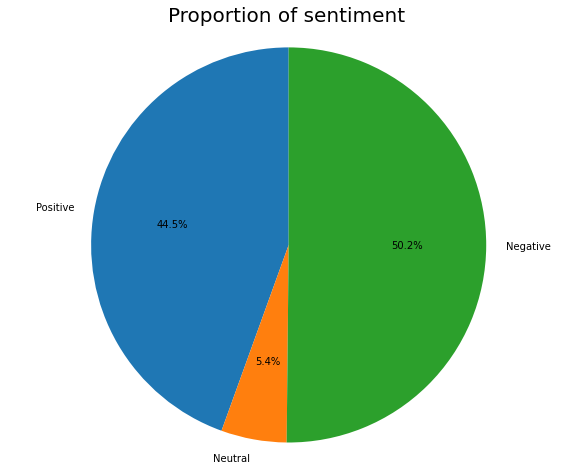

In [ ]:
labels = "Positive", "Neutral", "Negative"
sizes = [df_tweets["sentiment"][df_tweets["sentiment"]=="positive"].count(), df_tweets["sentiment"][df_tweets["sentiment"]=="neutral"].count(), df_tweets["sentiment"][df_tweets["sentiment"]=="negative"].count()]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')
plt.title("Proportion of sentiment", size = 20)
plt.show()

<AxesSubplot:xlabel='sentiment', ylabel='favorite_count'>

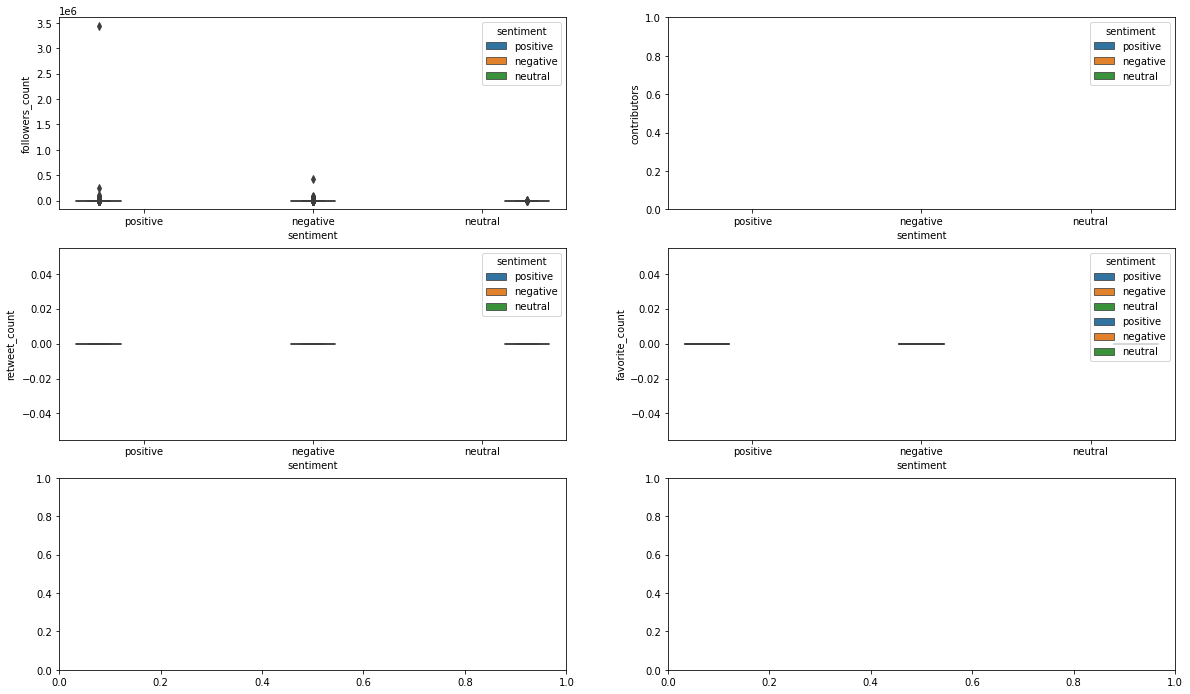

In [ ]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='followers_count',x = 'sentiment', hue = 'sentiment',data = df_tweets, ax=axarr[0][0])
sns.boxplot(y='contributors',x = 'sentiment', hue = 'sentiment',data = df_tweets, ax=axarr[0][1])
sns.boxplot(y='retweet_count',x = 'sentiment', hue = 'sentiment',data = df_tweets, ax=axarr[1][0])
sns.boxplot(y='reply_count',x = 'sentiment', hue = 'sentiment',data = df_tweets, ax=axarr[1][1])
sns.boxplot(y='favorite_count',x = 'sentiment', hue = 'sentiment',data = df_tweets, ax=axarr[1][1])

<AxesSubplot:xlabel='possibly_sensitive', ylabel='count'>

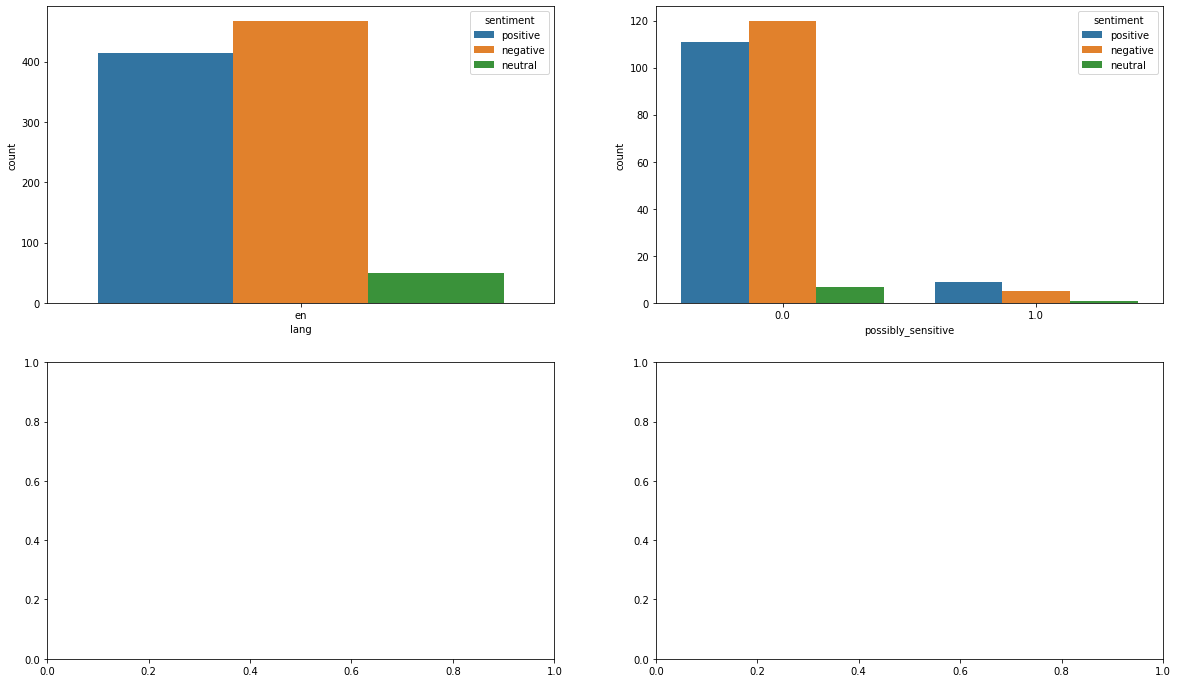

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='lang', hue = 'sentiment',data = df_tweets, ax=axarr[0][0])
sns.countplot(x='possibly_sensitive', hue = 'sentiment',data = df_tweets, ax=axarr[0][1])

In [ ]:
for col in df_tweets.columns:
    print(col)

created_at
id
id_str
text
source
truncated
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
user
geo
coordinates
place
contributors
retweeted_status
is_quote_status
quote_count
reply_count
retweet_count
favorite_count
entities
favorited
retweeted
filter_level
lang
timestamp_ms
display_text_range
extended_tweet
possibly_sensitive
quoted_status_id
quoted_status_id_str
quoted_status
quoted_status_permalink
extended_entities
neg_prob
pos_prob
sentiment
followers_count
